In [1]:
import os
import copy
import shutil
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

#### Plot nuclei positions and velocity

In [2]:
daystring = "10"
spotstring = "15"

fpath = "YuLong_Data/day_" + daystring + "/" + spotstring + "spot.csv"
dirname = "YuLong_Day" + daystring + "_Spot" + spotstring

df = pd.read_csv(fpath)
max_frame = np.max(list(df['FRAME']))
max_xlim = np.ceil(np.max(df['POSITION_X'])) + 1
max_ylim = np.ceil(np.max(df['POSITION_Y'])) + 1
max_zlim = np.ceil(np.max(df['POSITION_Z'])) + 1
min_xlim = np.floor(np.min(df['POSITION_X'])) - 1
min_ylim = np.floor(np.min(df['POSITION_Y'])) - 1
min_zlim = np.floor(np.min(df['POSITION_Z'])) - 1
max_lim = np.max([max_xlim, max_ylim, max_zlim])
min_lim = np.min([min_xlim, min_ylim, min_zlim])

In [3]:
show_quiver = False
show_track = True
show_com_mavv = False

odirname = dirname + "_plots"
if os.path.isdir(odirname):
    shutil.rmtree(odirname)
    os.mkdir(odirname)
else:
    os.mkdir(odirname)

for tp in range(1, max_frame+1):
        
    ipath = dirname + os.sep + "YuLong_Day" + daystring + "_Spot" + spotstring + "_Frame" + repr(tp) + ".npz"
    track_data = np.load(ipath)
    
    vpath = dirname + os.sep + "YuLong_Day" + daystring + "_Spot" + spotstring + "_Velocity" + repr(tp) + ".npz"
    vel_data = np.load(vpath)
    
    cell_pos = track_data["positions"]
    omega = vel_data["orientation"]
    
    plt.figure(figsize=(5,4), dpi=200)
    ax = plt.axes(projection='3d')
    
    ax.scatter3D(cell_pos[:,0], cell_pos[:,1], cell_pos[:,2], s=4, color='black')
    
    x_com = np.mean(cell_pos[:,0])
    y_com = np.mean(cell_pos[:,1])
    z_com = np.mean(cell_pos[:,2])
    
    if show_com_mavv:
        ax.quiver(x_com, y_com, z_com, omega[0], omega[1], omega[2], linewidth=1)
    
    for key in track_data.keys():
        
        if key == "positions":
            continue
        if key == "lumen1":
            continue
        if key == "lumen2":
            continue
        if key == "lumen3":
            continue
            
        cell_track = track_data[key]
        x_pos = cell_track[:,0][::-1]
        y_pos = cell_track[:,1][::-1]
        z_pos = cell_track[:,2][::-1]
        
        if show_track:
            ax.plot3D(x_pos, y_pos, z_pos, 'gray', linewidth=0.5)
        
        if show_quiver:
            try:
                cell_vel = vel_data[key]
                ax.quiver(x_pos[-1], y_pos[-1], z_pos[-1], cell_vel[0], cell_vel[1], cell_vel[2], 
                          length=2, normalize=True, linewidth=0.5, color='blue')
            except:
                continue
                
        ax.text(x_pos[-1], y_pos[-1], z_pos[-1], key, color='red', fontsize=4)
        
    outfname = "Frame" + repr(tp).zfill(3) + ".png"
    outfullpath = odirname + os.sep + outfname
    ax.set_xlim([min_lim, max_lim])
    ax.set_ylim([min_lim, max_lim])
    ax.set_zlim([min_lim, max_lim])
    plt.title("Spot " + spotstring + " (Frame: " + repr(tp) + ")", fontsize=8)
    plt.savefig(outfullpath)
    plt.close()

In [4]:
! cp make_png_movie.sh YuLong_Day10_Spot15_plots/

#### Plot representative lumens

In [5]:
def signed_vol_tri(p1, p2, p3):
    v321 = p3[0] * p2[1] * p1[2]
    v231 = p2[0] * p3[1] * p1[2]
    v312 = p3[0] * p1[1] * p2[2]
    v132 = p1[0] * p3[1] * p2[2]
    v213 = p2[0] * p1[1] * p3[2]
    v123 = p1[0] * p2[1] * p3[2]
    return (1.0/6.0)*(-v321 + v231 + v312 - v132 - v213 + v123)

def area_tri(p1, p2, p3):
    a = np.linalg.norm(p1-p2)
    b = np.linalg.norm(p2-p3)
    c = np.linalg.norm(p3-p1)
    s = (a+b+c)/2
    return np.sqrt(s*(s-a)*(s-b)*(s-c))

def mesh_vol(pt_coords, tri_indices):
    num_triangles = np.shape(tri_indices)[0]
    tot_vol = 0.0
    tot_area = 0.0
    for i in range(num_triangles):
        pt_indices = tri_indices[i,:]
        p1 = pt_coords[int(pt_indices[0])-1,:]
        p2 = pt_coords[int(pt_indices[1])-1,:]
        p3 = pt_coords[int(pt_indices[2])-1,:]
        tot_vol += signed_vol_tri(p1, p2, p3)
        tot_area += area_tri(p1, p2, p3)
    return (np.abs(tot_vol), tot_area)

In [6]:
dirname = "YuLong_Day" + daystring + "_Spot" + spotstring
odirname = dirname + "_lumen"
if os.path.isdir(odirname):
    shutil.rmtree(odirname)
    os.mkdir(odirname)
else:
    os.mkdir(odirname)

for tp in range(1, max_frame+1):
        
    ipath = dirname + os.sep + "YuLong_Day" + daystring + "_Spot" + spotstring + "_Frame" + repr(tp) + ".npz"
    track_data = np.load(ipath)
    
    cell_pos = track_data["positions"]
    
    lumens_exist = [True, True, True]
    lumens_poly3d_data = []
    lumens_fc_data = []
    lumens_ec_data = []
    lumens_stats = []
    fc_list = ["blue", "red", "green"]
    ec_list = ["darkblue", "maroon", "darkgreen"]
    
    for lumen_idx in range(1, 4):
        
        try:

            lumen_pts = track_data["lumen" + repr(lumen_idx)]

            mesh_size = mesh_vol(cell_pos, np.transpose(lumen_pts))

            num_triangles = np.shape(lumen_pts)[1]
            tri_data = np.zeros((num_triangles, 9))

            for tri in range(num_triangles):

                idx1 = int(lumen_pts[0, tri])-1
                idx2 = int(lumen_pts[1, tri])-1
                idx3 = int(lumen_pts[2, tri])-1

                coords = []
                coords.extend(cell_pos[idx1])
                coords.extend(cell_pos[idx2])
                coords.extend(cell_pos[idx3])
                tri_data[tri,:] = coords

            poly3d = [[tri_data[i, j*3:j*3+3] for j in range(3)] for i in range(num_triangles)]
            fc = [fc_list[lumen_idx-1] for i in range(num_triangles)]
            ec = [ec_list[lumen_idx-1] for i in range(num_triangles)]
            lumens_poly3d_data.append(poly3d)
            lumens_fc_data.append(fc)
            lumens_ec_data.append(ec)
            lumens_stats.append(mesh_size)

        except:
            lumens_exist[lumen_idx-1] = False
    
    fig = plt.figure(figsize=(5,4), dpi=200)
    ax = fig.add_subplot(111, projection='3d')
    
    # make axes
    ax_x = (min_lim, min_lim, min_lim)
    ax_y = (max_lim, max_lim, max_lim)
    ax_z = (min_lim, min_lim, min_lim)
    ax.scatter3D(min_lim, max_lim, min_lim, s=2, color="gray")
    ax_u, ax_v, ax_w = np.array([[1,0,0], [0,-1,0], [0,0,1]])
    ax.quiver(ax_x, ax_y, ax_z, ax_u, ax_v, ax_w, length=max_lim-min_lim, 
              linewidth=1.0, arrow_length_ratio=0.05, color='gray')
    
    # plot nuclei
    ax.scatter3D(cell_pos[:,0], cell_pos[:,1], cell_pos[:,2], s=4, color='black')
    
    for lumen_idx in range(1, 4):
        if lumens_exist[lumen_idx-1]:
            ax.add_collection3d(Poly3DCollection(lumens_poly3d_data[lumen_idx-1], 
                                                 facecolors=lumens_fc_data[lumen_idx-1], 
                                                 edgecolors=lumens_ec_data[lumen_idx-1], 
                                                 linewidths=0.3, linestyles=':', alpha=0.1))
    
    ax.set_xlim([min_lim, max_lim])
    ax.set_ylim([min_lim, max_lim])
    ax.set_zlim([min_lim, max_lim])
    ax.grid(False)
    plt.axis('off')
    
    outfname = "Frame" + repr(tp).zfill(3) + ".png"
    outfullpath = odirname + os.sep + outfname
    
    if lumens_exist[0]:
        
        lumen_vol = int(np.around(lumens_stats[0][0], decimals=0))
        lumen_sa = int(np.around(lumens_stats[0][1], decimals=0))
        plt.title("Spot " + spotstring + " (Frame: " + repr(tp) + ")" + 
                  "\n[Vol: " + repr(lumen_vol) + " $\mu m^3$, SArea: " + 
                  repr(lumen_sa) + " $\mu m^2$]", fontsize=8)
    else:
        
        plt.title("Spot " + spotstring + "(Frame: " + repr(tp) + ")" +
                  "\n(Vol: N/A, SArea: N/A)") 
    
    plt.savefig(outfullpath)
    plt.close()

In [7]:
! cp make_png_movie.sh YuLong_Day10_Spot15_lumen/

#### Track lumen associated cells

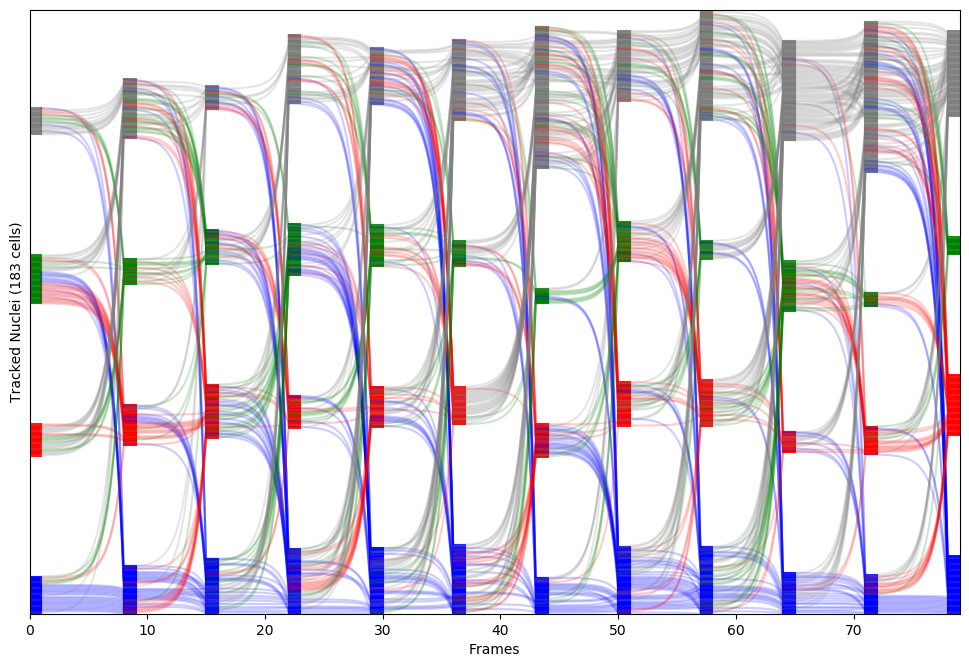

In [8]:
def interp_line(point1, point2):
    a = (point2[1] - point1[1])/(np.cosh(point2[0]) - np.cosh(point1[0]))
    b = point1[1] - a*np.cosh(point1[0])
    x = np.linspace(point1[0], point2[0], 100)
    y = a*np.cosh(x) + b
    return (x, y)

frame_step_size = 7

plt.figure(figsize=(12,8), dpi=100)

max_num_cells = 0
max_plot_y = 0

prev_line_segments = None
prev_num_cells = None

for tp in range(1, max_frame+1, frame_step_size):
        
    ipath = dirname + os.sep + "YuLong_Day" + daystring + "_Spot" + spotstring + "_Frame" + repr(tp) + ".npz"
    track_data = np.load(ipath)
    
    cell_pos = track_data["positions"]
    lumen1_cids = np.unique(track_data["lumen1"].flatten())
    lumen2_cids = np.unique(track_data["lumen2"].flatten())
    lumen3_cids = np.unique(track_data["lumen3"].flatten())
    
    num_cells = np.shape(cell_pos)[0]
    if num_cells > max_num_cells:
        max_num_cells = num_cells
        
    line_segments = dict()
    
    for cid in range(num_cells):
        
        in_lumen1 = (cid+1) in lumen1_cids
        in_lumen2 = (cid+1) in lumen2_cids
        in_lumen3 = (cid+1) in lumen3_cids
        
        if in_lumen3:
            line_segments[cid+1] = [[tp-frame_step_size, tp], 'g-', None, 0.2]
        elif in_lumen2:
            line_segments[cid+1] = [[tp-frame_step_size, tp], 'r-', None, 0.2]
        elif in_lumen1:
            line_segments[cid+1] = [[tp-frame_step_size, tp], 'b-', None, 0.2]
        else:
            line_segments[cid+1] = [[tp-frame_step_size, tp], 'gray', None, 0.2]
       
    plot_y = 0
    
    if prev_line_segments == None:
        for lclr in ['b-', 'r-', 'g-', 'gray']:
            for cid in range(num_cells):
                if line_segments[cid+1][1] == lclr:
                    plot_y += 1
                    line_segments[cid+1][2] = plot_y
                    plt.plot(line_segments[cid+1][0], [plot_y, plot_y], lclr, alpha=0.9)
            plot_y += 100
    else:
        for lclr in ['b-', 'r-', 'g-', 'gray']:
            for prevclr in ['b-', 'r-', 'g-', 'gray']:
                for cid in range(num_cells):
                    if line_segments[cid+1][1] == lclr:
                        if (cid+1) <= prev_num_cells:
                            if prev_line_segments[cid+1][1] == prevclr:
                                pt_start = [line_segments[cid+1][0][0], prev_line_segments[cid+1][2]]
                                pt_end = [line_segments[cid+1][0][1], plot_y]
                                xd, yd = interp_line(pt_start, pt_end)
                                plot_y += 1
                                line_segments[cid+1][2] = plot_y
                                plt.plot(xd, yd, lclr, alpha=line_segments[cid+1][3])
                                plt.plot([tp, tp+1], [plot_y, plot_y], lclr, alpha=0.9)
                        else:
                            plot_y += 1
                            line_segments[cid+1][2] = plot_y
                            plt.plot([tp, tp+1], [plot_y, plot_y], lclr, alpha=0.9)
            plot_y += 100
    
    prev_line_segments = copy.deepcopy(line_segments)
    prev_num_cells = num_cells
    if plot_y > max_plot_y:
        max_plot_y = plot_y
    
plt.yticks([])
plt.ylabel("Tracked Nuclei (" + repr(max_num_cells) + " cells)")
plt.xlabel("Frames")
plt.ylim([0, max_plot_y - 99])
plt.xlim([0, max_frame])
plt.show()